(normalization)=
# Normalization

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: preprocessing-visualization-normalization-key-takeaway-1
:link-type: ref
Normalization techniques like the shifted logarithm, scran, and analytic Pearson residuals are essential for adjusting single-cell RNA-seq data to account for technical variability and improve downstream analysis.
:::

```


<!-- START ENV-SETUP -->
``````{dropdown} <i class="fa-solid fa-gear"></i>   Environment setup
`````{tab-set}

````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} preprocessing_visualization.yml
:language: yaml
```
````

`````
``````
<!-- END ENV-SETUP -->

(preprocessing-visualization-normalization-key-takeaway-1)=
## Motivation

Up to this point, we removed low-quality cells, ambient RNA contamination and doublets from the dataset and the data is available as a count matrix in the form of a numeric matrix of shape cells x genes. These counts represent the capture, reverse transcription and sequencing of a molecule in the scRNA-seq experiment. Each of these steps adds a degree of variability to the measured count depth for identical cells, so the difference in gene expression between cells in the count data might simply be due to sampling effects. This means that the dataset and therefore the count matrix still contains widely varying variance terms. Analyzing the dataset is often challenging as many statistical methods assume data with uniform variance structure. 

```{admonition} Gamma-Poisson distribution
A theoretically and empirically established model for UMI data is the Gamma-Poisson distribution which implies a quadratic mean-variance relation with $\operatorname{Var}[Y] = \mu + \alpha \mu^2$ with mean $\mu$ and overdispersion $\alpha$. For $\alpha=0$ this is the Poisson distribution and $\alpha$ describes the additional variance on top of the Poisson. 
```

The preprocessing step of "normalization" aims to adjust the raw counts in the dataset for variable sampling effects by scaling the observable variance to a specified range. Several normalization techniques are used in practice varying in complexity. They are mostly designed in such a way that subsequent analysis tasks and their underlying statistical methods are applicable. 

A recent benchmark published by Ahlmann-Eltze and Huber{cite}`Ahlmann-Eltze2023` compared 22 different transformations for single-cell data. The benchmark compared the performance of the different normalization techniques based on the cell graph overlap with the ground truth. We would like to highlight that a complete benchmark which also compares the impact of the normalization on a variety of different downstream analysis tasks is still outstanding. We advise analysts to choose the normalization carefully and always depend on the subsequent analysis task. 

This chapter will introduce the reader to three different normalization techniques, the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals. The shifted logarithm works beneficial for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes. Scran was extensively tested and used for batch correction tasks and analytic Pearson residuals are well suited for selecting biologically variable genes and identification of rare cell types. 

We first import all required Python packages and load the dataset for which we filtered low quality cells, removed ambient RNA and scored doublets. 



In [1]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import issparse

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
adata = sc.read(
    filename="s4d8_quality_control.h5ad",
    backup_url="https://figshare.com/ndownloader/files/40014331",
)

We can now inspect the distribution of the raw counts which we already calculated during quality control. This step can be neglected during a standard single-cell analysis pipeline, but might be helpful to understand the different normalization concepts. 

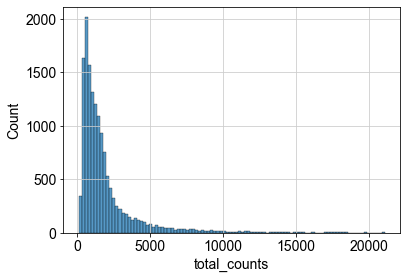

In [3]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

## Shifted logarithm 

The first normalization technique we will introduce is the shifted logarithm which is based on the delta method {cite}`dorfman1938note`. The delta method applies a nonlinear function $f(Y)$ to the raw counts $Y$ and aims to make the variances across the dataset more similar. 

The shifted logarithm tackles this by 

$$f(y) = \log\left(\frac{y}{s}+y_0\right)$$ 

with $y$ being the raw counts, $s$ being a so-called size factor and $y_0$ describing a pseudo-count. The size factors are determined for each cell to account for variations in sampling effects and different cell sizes. The size factor for a cell $c$ can be calculated by 

$$s_c = \frac{\sum_g y_{gc}}{L}$$ 

with $g$ indexing different genes and $L$ describing a target sum. There are different approaches to determine the size factors from the data. We will leverage the scanpy default in this section with $L$ being the median raw count depth in the dataset. Many analysis templates use fixed values for $L$, for example $L=10^5$, or $L=10^6$ resulting in values commonly known as counts per million (CPM). For a beginner, these values may seem arbitrary, but it can lead to much larger overdispersions than typically seen in single-cell datasets. 

```{admonition} Overdispersion
Overdispersion describes the presence of a greater variability in the dataset than one would expect.
```

The shifted logarithm is a fast normalization technique, outperforms other methods for uncovering the latent structure of the dataset (especially when followed by principal component analysis) and works beneficial for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes. We will now inspect how to apply this normalization method to our dataset. The shifted logarithm can be conveniently called with scanpy by running `pp.normalize_total` with `target_sum=None`. We are setting the `inplace` parameter to `False` as we want to explore three different normalization techniques in this tutorial. The second step now uses the scaled counts and we obtained the first normalized count matrix.


In [4]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

We can now inspect how the distribution of our counts changed after we applied the shifted logarithm and compare it to the total count from our raw (but filtered) dataset.

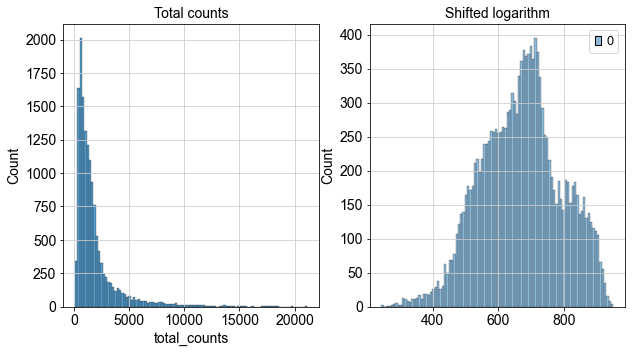

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

A second normalization method, which is also based on the delta method, is Scran's pooling-based size factor estimation method. Scran follows the same principles as the shifted logarithm by calculating $f(y) = \log(\frac{y}{s}+y_0)$ with $y$ being the raw counts, $s$ the size factor and $y_0$ describing a pseudo-count. The only difference now is that Scran leverages a deconvolution approach to estimate the size factors based on a linear regression over genes for pools of cells. This approach aims to better account for differences in count depths across all cells present in the dataset.

Cells are partitioned into pools and Scran estimates pool-based size factors using a linear regression over genes. Scran was extensively tested for batch correction tasks and can be easily called with the respective R package.

In [6]:
from scipy.sparse import csr_matrix

In [7]:
%%R
library(scran)
library(BiocParallel)

scran requires a coarse clustering input to improve size factor estimation performance. In this tutorial, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

In [8]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

We now add `data_mat` and our computed groups into our R environment. 

In [9]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

We can now also delete the copy of our anndata object, as we obtained all objects needed in order to run scran. 

In [10]:
del adata_pp

We now compute the size factors based on the groups of cells we calculated before. 

In [11]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

We save `size_factors` in `.obs` and are now able to normalize the data and subsequently apply a log1p transformation.

In [12]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

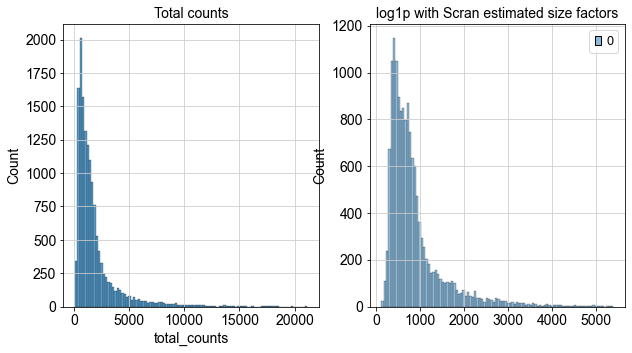

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

## Analytic Pearson residuals

The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from 'regularized negative binomial regression' to calculate a model of technical noise in the data. It explicitly adds the count depth as a covariate in a generalized linear model. {cite}`norm:germain_pipecomp_2020` showed in an independent comparison of different normalization techniques that this method removed the impact of sampling effects while preserving cell heterogeneity in the dataset. Notably, analytic Pearson residuals do not require downstream heuristic steps like pseudo count addition or log-transformation.
​
The output of this method are normalized values that can be positive or negative. Negative residuals for a cell and gene indicate that less counts are observed than expected compared to the gene's average expression and cellular sequencing depth. Positive residuals indicate the more counts respectively. Analytic Pearson residuals are implemented in scanpy and can directly be calculated on the raw count matrix.


In [14]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

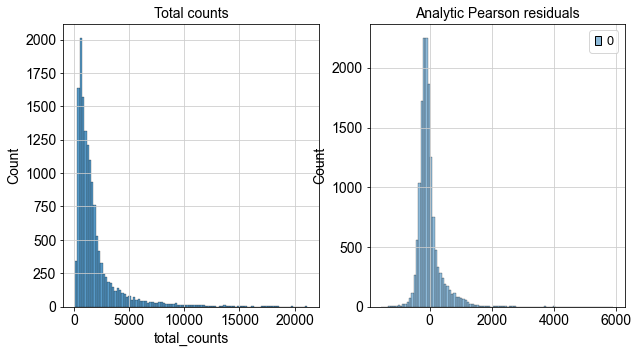

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

We applied different normalization techniques to our dataset and saved them as separate layers to our anndata object. Depending on the downstream analysis task it can be favourable to use a differently normalized layer and assess the result.

In [16]:
adata.write("s4d8_normalization.h5ad")

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: norm
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anna Schaar

### Reviewers

* Lukas Heumos